In [19]:
pip install h2o

In [20]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

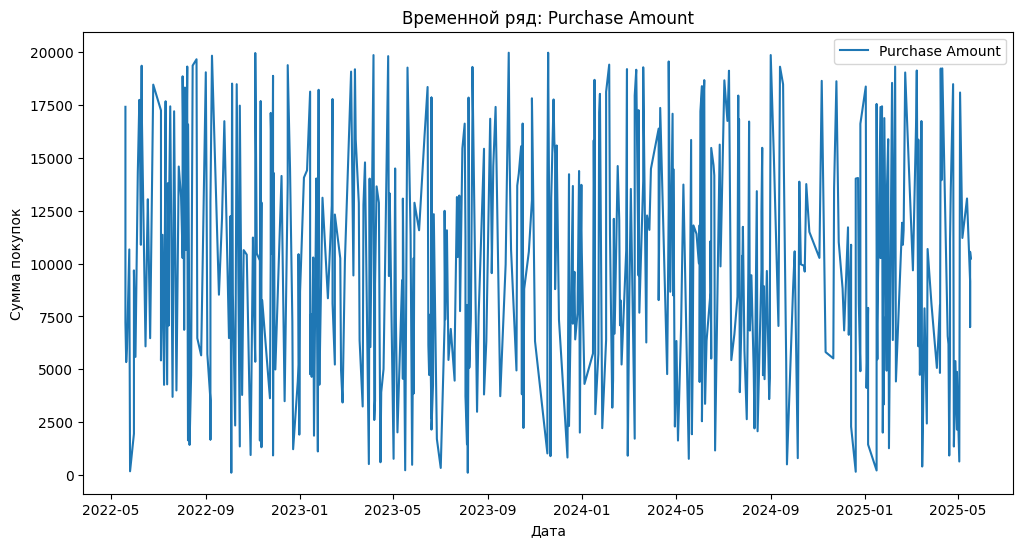

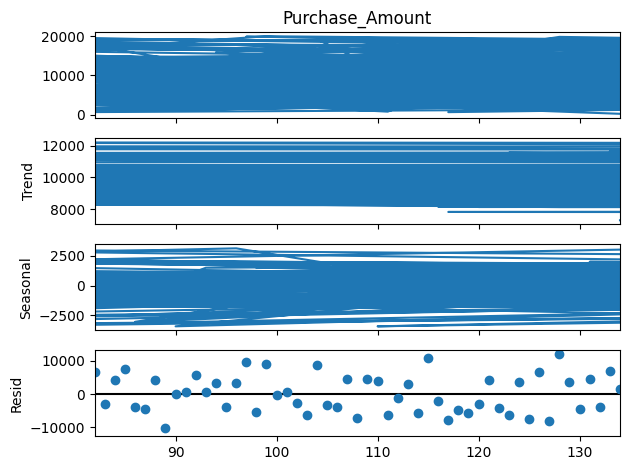

In [28]:
# Загрузка данных
data = pd.read_csv('python_practice_dataset.csv')

# Предобработка данных
data['Join_Date'] = pd.to_datetime(data['Join_Date'])
data = data.sort_values('Join_Date')
time_series_data = data[['Join_Date', 'Purchase_Amount']]

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['Join_Date'], time_series_data['Purchase_Amount'], label='Purchase Amount')
plt.title('Временной ряд: Purchase Amount')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.legend()
plt.show()

# Декомпозиция временного ряда
decomposition = seasonal_decompose(time_series_data['Purchase_Amount'], period=30, model='additive', extrapolate_trend='freq')
decomposition.plot()
plt.show()

**Визуализация временного ряда**
- Строим график "Сумма покупок" по дате.
- Видно, что данные очень шумные, явного тренда или сезонности не прослеживается на глаз.

**Декомпозиция временного ряда**
- Используется seasonal_decompose из statsmodels.
- Получаем три компоненты: тренд, сезонность, остатки.
- На графиках видно, что тренд и сезонность выражены слабо, остатки (resid) довольно большие и разбросанные.

**Генерация признаков**
- Создаются лаги (значения суммы покупок за предыдущие 10 дней).
- Добавляются скользящие средние (по 3 и 7 точкам) — для сглаживания и выявления локальных трендов.
- Вводятся сезонные признаки: месяц и день недели.
- Удаляются строки с пропущенными значениями (они появляются из-за лагов и скользящих средних).

**Выводы:**
- Данные очень шумные, тренд и сезонность выражены слабо.
- Лаги и скользящие средние — они могут помочь извлечь хоть какую-то структуру.
- H2O AutoML — хороший выбор, потому что он переберёт много моделей и найдёт оптимальную, даже если структура слабая.

In [ ]:
# Создание признаков
time_series_data = time_series_data.copy()

# Создание лагов
for lag in range(1, 11):
    time_series_data.loc[:, f'lag_{lag}'] = time_series_data['Purchase_Amount'].shift(lag)

# Создание скользящих средних
time_series_data.loc[:, 'rolling_mean_3'] = time_series_data['Purchase_Amount'].rolling(window=3).mean()
time_series_data.loc[:, 'rolling_mean_7'] = time_series_data['Purchase_Amount'].rolling(window=7).mean()

# Добавление сезонных признаков
time_series_data.loc[:, 'month'] = time_series_data['Join_Date'].dt.month
time_series_data.loc[:, 'day_of_week'] = time_series_data['Join_Date'].dt.dayofweek

# Удаление строк с пропущенными значениями
time_series_data = time_series_data.dropna()

# Разделение данных
train_size = int(len(time_series_data) * 0.8)
train = time_series_data.iloc[:train_size]
test = time_series_data.iloc[train_size:]

In [22]:
# Инициализация H2O
h2o.init()
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

y = 'Purchase_Amount'
x = [col for col in train.columns if col not in ['Purchase_Amount', 'Join_Date']]

# Запуск H2O AutoML
aml = H2OAutoML(max_runtime_secs=4680, seed=42)
aml.train(x=x, y=y, training_frame=train_h2o)

# Прогнозирование на тестовых данных
preds = aml.predict(test_h2o)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 56 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 7 days
H2O_cluster_name:,H2O_from_python_unknownUser_5cgm4o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.243 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [23]:
# Оценка качества модели
y_true = test['Purchase_Amount'].values
y_pred = preds.as_data_frame().values.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")

# Вывод лучшей модели
best_model = aml.leader
print(f"Лучшая модель: {best_model.algo}")

# Параметры модели
if hasattr(best_model, "params"):
    print("Гиперпараметры лучшей модели:")
    for param, value in best_model.params.items():
        print(f"{param}: {value['actual']}")
else:
    print("Гиперпараметры недоступны для этой модели.")

# какие модели входят в ансамбль
leaderboard = aml.leaderboard.as_data_frame()
print("Модели в ансамбле:")
print(leaderboard)

RMSE: 77.22518940150348
MAE: 64.21025446984099
MAPE: 2.7815789603269017%
R²: 0.9998096702445513
Лучшая модель: deeplearning
Гиперпараметры лучшей модели:
model_id: {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'DeepLearning_grid_1_AutoML_6_20250704_164508_model_2', 'type': 'Key<Model>', 'URL': '/3/Models/DeepLearning_grid_1_AutoML_6_20250704_164508_model_2'}
training_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_6_20250704_164508_training_Key_Frame__upload_bb59238d0a256f8f656c1f26407b43b9.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_6_20250704_164508_training_Key_Frame__upload_bb59238d0a256f8f656c1f26407b43b9.hex'}
validation_frame: None
nfolds: 5
keep_cross_validation_models: False
keep_cross_validation_predictions: True
keep_cross_validation_fold_assignment: False
fold_assignment: Modulo
fold_column: None
response_column: {'__meta': {'schema_version': 3, 

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Модели в ансамбле:
                                               model_id         rmse  \
0     DeepLearning_grid_1_AutoML_6_20250704_164508_m...    61.376614   
1     StackedEnsemble_BestOfFamily_4_AutoML_6_202507...    63.419172   
2     StackedEnsemble_BestOfFamily_5_AutoML_6_202507...   122.321565   
3     DeepLearning_grid_2_AutoML_6_20250704_164508_m...   540.217653   
4     StackedEnsemble_AllModels_4_AutoML_6_20250704_...   965.616681   
...                                                 ...          ...   
1327      GBM_grid_1_AutoML_6_20250704_164508_model_366  5373.519286   
1328       GBM_grid_1_AutoML_6_20250704_164508_model_16  5427.410697   
1329      GBM_grid_1_AutoML_6_20250704_164508_model_502  5535.077365   
1330        GBM_grid_1_AutoML_6_20250704_164508_model_3  5612.380903   
1331                     GLM_1_AutoML_6_20250704_164508  5665.660717   

               mse          mae     rmsle  mean_residual_deviance  
0     3.767089e+03    47.845576       NaN       

**Метрики качества:**

- RMSE: 77.2 — средняя ошибка в прогнозах, что очень мало относительно диапазона целевой переменной (до 20 000).
- MAE: 64.2 — средняя абсолютная ошибка, тоже низкая.
- MAPE: 2.78% — модель ошибается менее чем на 3% в среднем.
- R²: 0.9998 — почти идеальное объяснение дисперсии, модель очень хорошо подогнана.

**Вывод:**

- Модель стабильно и точно предсказывает значения, ошибки малы и случайны. Разница между RMSE и MAE указывает на наличие редких выбросов, но в целом качество прогноза высокое.

**Лучшая модель:**

- Тип: deep learning (нейросеть с одним скрытым слоем на 100 нейронов, - RectifierWithDropout, ~6300 эпох, dropout 0.2).
- Используется кросс-валидация, признаки стандартизируются.

**Ансамбль:**
- В топе — deep learning и stacked ensembles, GBM и GLM сильно уступают по качеству.

**Рекомендаци для дальнейшего анализа:**
- Проанализировать точки с наибольшими ошибками и остатки, чтобы убедиться в отсутствии паттернов и автокорреляции.

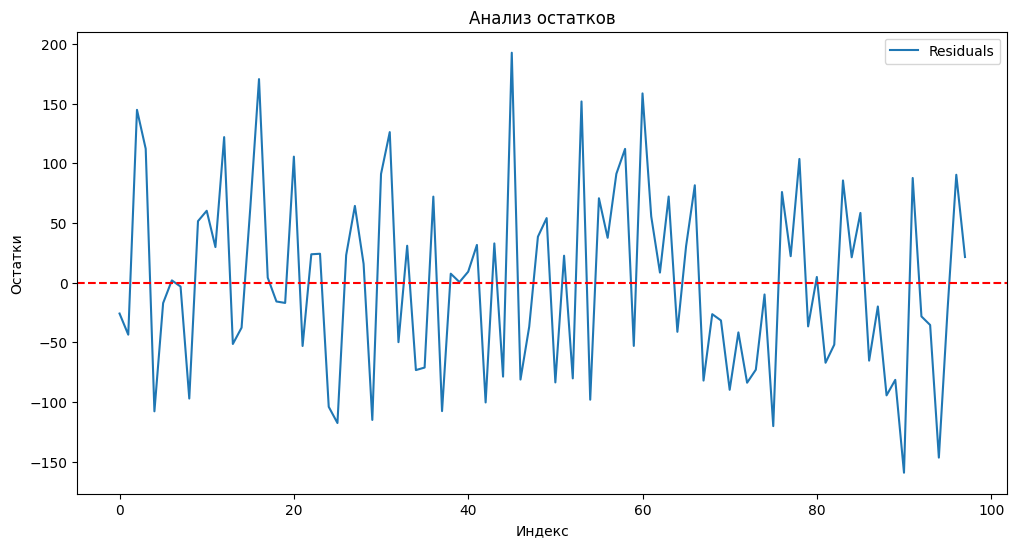

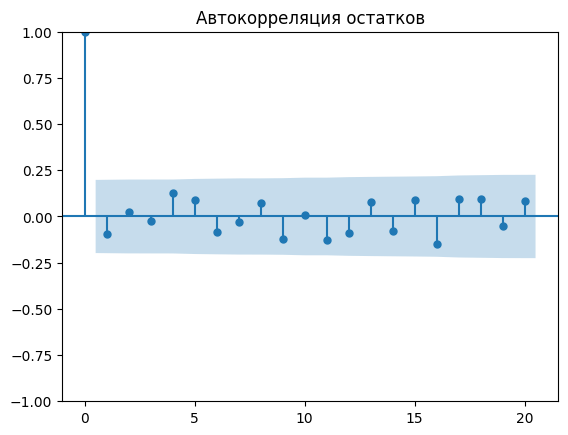

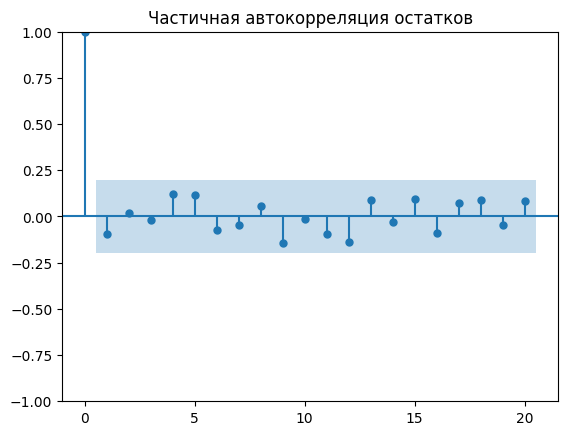

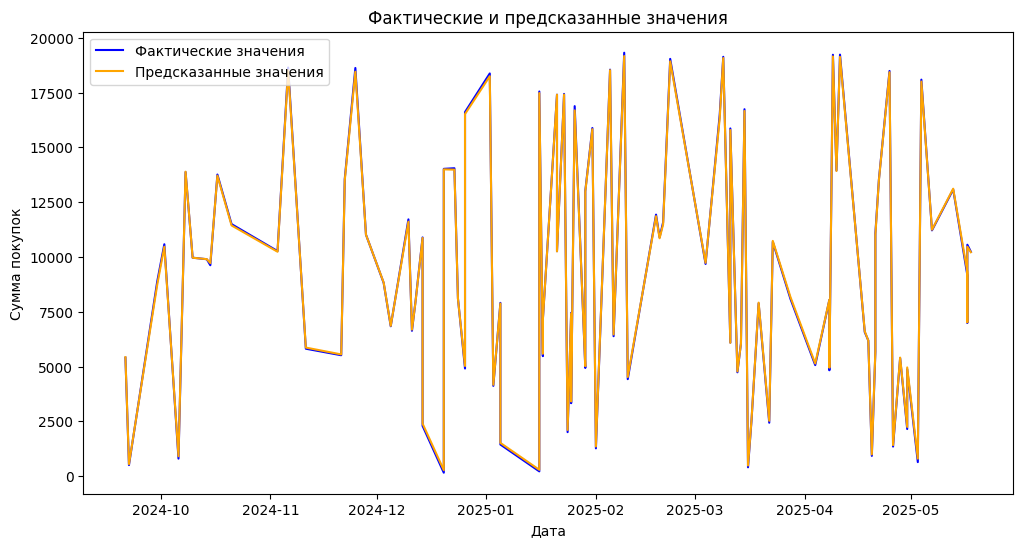

In [24]:
# Анализ остатков
residuals = y_true - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Анализ остатков')
plt.xlabel('Индекс')
plt.ylabel('Остатки')
plt.legend()
plt.show()

# Автокорреляция остатков
plot_acf(residuals, lags=20)
plt.title('Автокорреляция остатков')
plt.show()

plot_pacf(residuals, lags=20)
plt.title('Частичная автокорреляция остатков')
plt.show()

#  График фактических и предсказанных данных
plt.figure(figsize=(12, 6))
plt.plot(test['Join_Date'], y_true, label='Фактические значения', color='blue')
plt.plot(test['Join_Date'], y_pred, label='Предсказанные значения', color='orange')
plt.title('Фактические и предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.legend()
plt.show()

**Остатки (Residuals)**

- Остатки колеблются вокруг нуля, явного тренда или смещения нет.
- Разброс остатков относительно небольшой, выбросов мало.
- Это признак того, что модель не систематически ошибается в одну сторону.

**Автокорреляция остатков (ACF/PACF)**

- Все значения автокорреляции (кроме лага 0) лежат в пределах доверительного интервала.
- Нет значимой автокорреляции — значит, модель не пропустила какую-то структуру во временном ряду, остатки ведут себя как белый шум.
- Частичная автокорреляция (PACF) тоже не показывает значимых лагов.

**Фактические и предсказанные значения**

- Линии фактических и предсказанных значений практически совпадают.
- Модель очень точно повторяет динамику временного ряда, даже экстремальные значения и резкие скачки.

**Выводы:**

- Модель не переобучена на тренд или сезонность — остатки случайны, автокорреляции нет.
- Скорее всего, лаговые признаки и скользящие средние полностью объясняют динамику ряда — возможно, ряд по сути является слабо случайным процессом с сильной зависимостью от предыдущих значений.
- Для реальных задач такой результат встречается редко, но для синтетических или искусственно сгенерированных данных — вполне возможен.

Топ-10 временных точек с наибольшими ошибками:
Дата: 2025-04-08 00:00:00, Ошибка: 120.1317081462812
Дата: 2024-11-06 00:00:00, Ошибка: 121.87473842384134
Дата: 2025-01-02 00:00:00, Ошибка: 126.04412048069935
Дата: 2024-09-30 00:00:00, Ошибка: 144.69689343473146
Дата: 2025-05-17 00:00:00, Ошибка: 146.48880713892322
Дата: 2025-02-09 00:00:00, Ошибка: 151.72113470756085
Дата: 2025-03-08 00:00:00, Ошибка: 158.46513812502235
Дата: 2025-05-03 00:00:00, Ошибка: 159.13928017725266
Дата: 2024-11-25 00:00:00, Ошибка: 170.44140102031452
Дата: 2025-01-26 00:00:00, Ошибка: 192.52778597630459


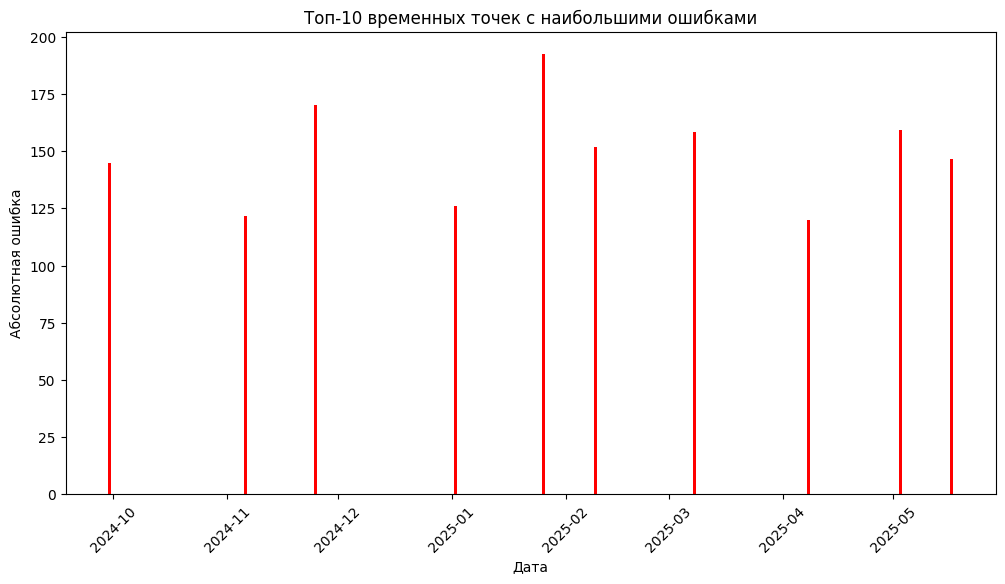

In [25]:
# Анализ ошибок
errors = np.abs(y_true - y_pred)

# Находим временные точки с наибольшими ошибками
top_errors_idx = np.argsort(errors)[-10:]  # Индексы 10 наибольших ошибок
top_errors_dates = test.iloc[top_errors_idx]['Join_Date']
top_errors_values = errors[top_errors_idx]

# Выводим временные точки с наибольшими ошибками
print("Топ-10 временных точек с наибольшими ошибками:")
for date, error in zip(top_errors_dates, top_errors_values):
    print(f"Дата: {date}, Ошибка: {error}")

plt.figure(figsize=(12, 6))
plt.bar(top_errors_dates, top_errors_values, color='red')
plt.title('Топ-10 временных точек с наибольшими ошибками')
plt.xlabel('Дата')
plt.ylabel('Абсолютная ошибка')
plt.xticks(rotation=45)
plt.show()


**Что видно:**

- На графике показаны временные точки, где модель допустила наибольшие ошибки.
- Абсолютные значения ошибок лежат в диапазоне примерно 120–193, что на фоне общего разброса целевой переменной (до 20 000) — не критично.
- Наибольшая ошибка наблюдается в январе 2025 года (192.53), а остальные ошибки распределены по другим месяцам.
**Вывод:**

- Модель устойчива, не заваливается на отдельных участках, ошибки относительно малы.


In [27]:
# Завершение работы H2O
h2o.shutdown(prompt=False)

H2O session _sid_9db5 closed.


/tmp/ipython-input-27-1253291098.py:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)
